In [ ]:
%pip install torchviz

In [47]:
%pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 51.7 MB/s eta 0:00:00


# Import libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import os

from __future__ import print_function, division

import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import torch.nn.functional as F

In [2]:
# prompt: login in drive to have a pth

from google.colab import drive
drive.mount('/content/drive')

data = '/content/drive/My Drive/AI_ML_course_2_term/DL_project/'
# You can now access files in your Google Drive at /content/drive/My Drive/
# For example, to load a .pth file:
# model = torch.load('/content/drive/My Drive/my_model.pth')

Mounted at /content/drive


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Initial Hyperameters

In [4]:
# Hyperparameters for a custom CNN
NUM_EPOCHS = 25  # May need more epochs when training from scratch
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_CLASSES = 10 # Your 10 food classes

# Loading the Dataset

In [7]:
# import os
# def get_data_extract():
#   if "food-101" in os.listdir():
#     print("Dataset already exists")
#   else:
#     print("Downloading the data...")
#     !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
#     print("Dataset downloaded!")
#     print("Extracting data..")
#     !tar xzvf food-101.tar.gz
#     print("Extraction done!")

In [ ]:
# get_data_extract()

In [5]:
# # prompt: !tar xzvf food-101.tar.gz and extract in a drive folder

# # Define the destination path in Google Drive
drive_destination = '/content/drive/MyDrive/AI_ML_course_2_term/DL_project/food-101/'

# # Create the directory in Drive if it doesn't exist
os.makedirs(drive_destination, exist_ok=True)

print(f"Extracting data to {drive_destination}")

# # Extract the tar.gz file directly into the Google Drive directory
# # The -C option changes the directory before extracting
# !tar xzvf food-101.tar.gz -C "{drive_destination}"

# print("Extraction done!")

Extracting data to /content/drive/MyDrive/AI_ML_course_2_term/DL_project/food-101/


What has inside food-101 folder?

meta folder contains the text files - train.txt and test.txt

train.txt contains the list of images that belong to training set

test.txt contains the list of images that belong to test set

classes.txt contains the list of all classes of food

In [6]:
# Helper method to split dataset into train and test folders
from shutil import copy
from collections import defaultdict
import os

def prepare_data(filepath, src, dest):
  """
  Organizes images from a source directory into train/test folders based on a list of image paths.

  Args:
      filepath (str): Path to the text file containing image paths (e.g., train.txt, test.txt).
      src (str): Source directory containing the original images.
      dest (str): Destination directory where the organized images will be placed.
  """
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        # Assuming the format is 'class_name/image_name' in the text file
        food_class, image_name = p.split('/')
        classes_images[food_class].append(image_name + '.jpg') # Append .jpg if not present

  for food in classes_images.keys():
    print(f"\nCopying images into {food}")
    # Create the class directory in the destination if it doesn't exist
    class_dest_dir = os.path.join(dest, food)
    if not os.path.exists(class_dest_dir):
      os.makedirs(class_dest_dir)

    # Copy each image to the corresponding class directory
    for i in classes_images[food]:
      source_image_path = os.path.join(src, food, i)
      destination_image_path = os.path.join(class_dest_dir, i)
      # Check if the source file exists before attempting to copy
      if os.path.exists(source_image_path):
          copy(source_image_path, destination_image_path)
      else:
          print(f"Warning: Source file not found: {source_image_path}")

  print("Copying Done!")

# Assuming 'data' and 'drive_destination' are defined from the preceding code

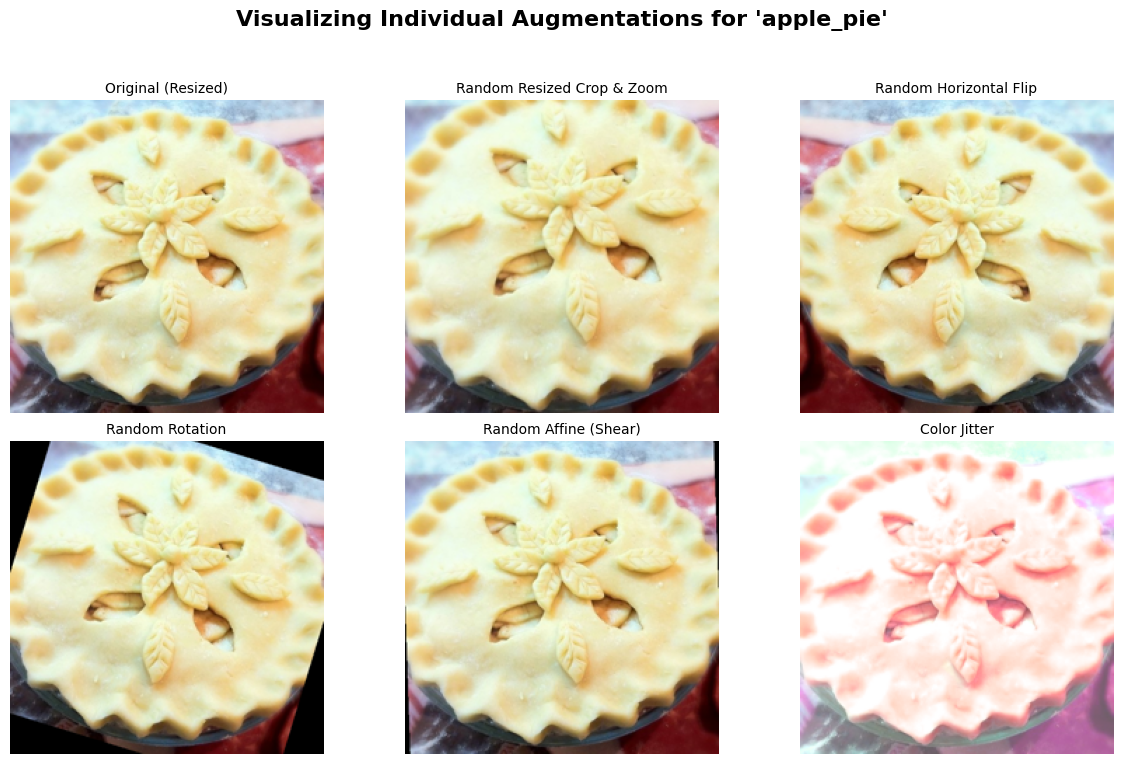

In [7]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

# --- 1. DEFINE THE PATHS AND LOAD ONE IMAGE ---
# IMPORTANT: Update './your_main_data_folder' to your actual data path.
base_data_dir = '/content/drive/MyDrive/AI_ML_course_2_term/DL_project/food-101/'
class_name = 'apple_pie' # Change this to any of your 10 class names
class_path = os.path.join(base_data_dir, 'train', class_name)

# Check if the path exists
if not os.path.isdir(class_path):
    print(f"Error: Directory not found at '{class_path}'")
    print("Please make sure your 'base_data_dir' is correct and the class folder exists.")
else:
    # Get a list of all image files
    image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if not image_files:
        print(f"No images found in the directory: {class_path}")
    else:
        # Load the first image using PIL
        original_image = Image.open(image_files[0]).convert('RGB')

        # --- 2. DEFINE INDIVIDUAL AUGMENTATION OPERATIONS ---
        # We define each major augmentation separately to visualize its effect.
        # Note: p=1.0 for flip ensures it always happens for the demo.
        augmentation_list = [
            ("Random Resized Crop & Zoom", transforms.RandomResizedCrop(224, scale=(0.6, 1.0))),
            ("Random Horizontal Flip", transforms.RandomHorizontalFlip(p=1.0)),
            ("Random Rotation", transforms.RandomRotation(30)),
            ("Random Affine (Shear)", transforms.RandomAffine(degrees=0, shear=15)),
            ("Color Jitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2))
        ]

        # --- 3. VISUALIZE THE ORIGINAL AND AUGMENTED IMAGES ---

        # Helper function to display a PIL image
        def show_pil_image(pil_img, title=None):
            plt.imshow(pil_img)
            if title:
                plt.title(title, fontsize=10)
            plt.axis('off')

        # Create a plot to display the images
        plt.figure(figsize=(12, 8))
        plt.suptitle(f"Visualizing Individual Augmentations for '{class_name}'", fontsize=16, weight='bold')

        # Display the original image (resized for fair comparison)
        plt.subplot(2, 3, 1)
        show_pil_image(original_image.resize((224, 224)), title="Original (Resized)")

        # Loop through the list of augmentations and display each one
        for i, (title, transform) in enumerate(augmentation_list):
            # Apply the single augmentation to the original image
            augmented_image = transform(original_image)

            plt.subplot(2, 3, i + 2)
            # We resize the output to 224x224 for consistent display if not already done
            if augmented_image.size != (224, 224):
                 augmented_image = augmented_image.resize((224, 224))
            show_pil_image(augmented_image, title=title)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Data Preprocessing

Perform data preprocessing steps such as resizing images, normalizing pixel values, and splitting the dataset into training, validation, and test sets.

Apply data augmentation techniques to increase the diversity of the training data.

Organize train, test and validation datasets

In [ ]:
# import os
# import shutil
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor
# from functools import partial

# # === CHECK GPU AVAILABILITY ===
# try:
#     import torch
#     print("🧠 PyTorch GPU available:", torch.cuda.is_available())
#     if torch.cuda.is_available():
#         print("🖥️ GPU name:", torch.cuda.get_device_name(0))
# except ImportError:
#     try:
#         import tensorflow as tf
#         gpus = tf.config.list_physical_devices('GPU')
#         print("🧠 TensorFlow GPU available:", len(gpus) > 0)
#         if gpus:
#             print("🖥️ GPU name:", gpus[0].name)
#     except ImportError:
#         print("⚠️ Neither PyTorch nor TensorFlow found. GPU status unknown.")

# # === CONFIGURATION: SELECT FIRST 20 CLASSES ===
# NUM_CLASSES_TO_USE = 20
# classes_file = os.path.join(drive_destination, 'meta', 'classes.txt')

# print(f"🎯 Reading class list from: {classes_file}")
# with open(classes_file, 'r') as f:
#     # Use a set for highly efficient O(1) average time complexity lookups
#     classes_to_copy = set([line.strip() for line in f.readlines()[:NUM_CLASSES_TO_USE]])

# print(f"✅ Successfully selected the first {len(classes_to_copy)} classes to copy.")

# # === FILE COPYING SETUP ===
# train_source = os.path.join(drive_destination, 'images')
# test_source = os.path.join(drive_destination, 'images')

#train_destination = os.path.join(data, 'food-101', 'train')
#test_destination = os.path.join(data, 'food-101', 'test')

# os.makedirs(train_destination, exist_ok=True)
# os.makedirs(test_destination, exist_ok=True)

# # === DEFINE COPYING FUNCTION (Unchanged) ===
# def copy_file(file_path, source_dir, dest_dir):
#     """Copies a single file to its class-specific destination directory."""
#     file_path = file_path.strip()
#     src = os.path.join(source_dir, file_path + '.jpg')
#     class_name = file_path.split('/')[0]

#     # The destination directory for this specific class
#     dst_class_dir = os.path.join(dest_dir, class_name)
#     os.makedirs(dst_class_dir, exist_ok=True)

#     # The final destination path for the image file
#     dst = os.path.join(dst_class_dir, os.path.basename(file_path) + '.jpg')

#     try:
#         shutil.copyfile(src, dst)
#     except FileNotFoundError:
#         print(f"⚠️ Missing file: {src}")

# # === MULTITHREADED DATA PREP FUNCTION (Modified) ===
# def prepare_data_multithreaded(list_path, source_dir, dest_dir, allowed_classes, max_workers=16):
#     """
#     Reads a file list, filters it for allowed classes, and copies files in parallel.
#     """
#     with open(list_path, 'r') as f:
#         all_lines = f.readlines()

#     # Filter the list to only include files from the allowed classes
#     filtered_lines = [
#         line for line in all_lines if line.strip().split('/')[0] in allowed_classes
#     ]

#     if not filtered_lines:
#         print(f"❌ No files found for the selected classes in {os.path.basename(list_path)}. Please check paths and class names.")
#         return

#     print(f"Found {len(filtered_lines)} files to copy from {os.path.basename(list_path)}.")

#     # Use the filtered list for copying
#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         # The partial function pre-fills arguments for the copy_file function
#         copy_func = partial(copy_file, source_dir=source_dir, dest_dir=dest_dir)
#         # map applies the copy_func to every item in filtered_lines
#         list(tqdm(executor.map(copy_func, filtered_lines),
#                   total=len(filtered_lines),
#                   desc=f"Copying to {os.path.basename(dest_dir)}"))

# # === PREPARE DATA (Modified) ===
# print("\n🚀 Preparing training data with multithreading...")
# prepare_data_multithreaded(os.path.join(drive_destination, 'meta', 'train.txt'),
#                            train_source,
#                            train_destination,
#                            classes_to_copy) # Pass the set of allowed classes

# print("\n🚀 Preparing testing data with multithreading...")
# prepare_data_multithreaded(os.path.join(drive_destination, 'meta', 'test.txt'),
#                            test_source,
#                            test_destination,
#                            classes_to_copy) # Pass the set of allowed classes

# print("\n✅ Data preparation complete for the first 20 classes!")


In [ ]:
classes = ['Bruschetta', 'Beet salad', 'Chicken quesadilla', 'Apple pie', 'Beef tartare', 'Breakfast burrito', 'Caesar salad', 'Cannoli', 'Baklava', 'Beef carpaccio']

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

In [9]:
# Visualize the data, showing one image per class from 101 classes
rows = 2
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/drive/MyDrive/AI_ML_course_2_term/DL_project/food-101/train/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

Output hidden; open in https://colab.research.google.com to view.

# Getting Image Resolution

In [10]:
# prompt: get image resolution

from PIL import Image

train_destination = os.path.join(data, 'food-101', 'train')

# Assuming you have an image file path, replace 'path/to/your/image.jpg' with the actual path
# For example, if you want to check the resolution of an image from the dataset:
image_path = os.path.join(train_destination, 'apple_pie', '85857.jpg') # Replace with a valid image path

try:
  with Image.open(image_path) as img:
    width, height = img.size
    print(f"Image Resolution: {width}x{height}")
except FileNotFoundError:
  print(f"Error: Image file not found at {image_path}")
except Exception as e:
  print(f"An error occurred: {e}")


Image Resolution: 384x512


# Resizing, Converting to a Tensor, and Normalizing

In [11]:
print("Setting up data transformations with ALL augmentation features...")
# Define the most comprehensive augmentations for the training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Handles zoom and translation
    transforms.RandomHorizontalFlip(),
    # Using RandomAffine to add rotation and shearing
    transforms.RandomAffine(degrees=15, shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define a separate, non-augmenting pipeline for validation and testing
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 3. CREATE DATASETS USING ImageFolder ---
print("Loading data from folders...")
# This automatically loads images and assigns labels based on the folder structure
# Use the correct paths from the previous steps
train_dataset = datasets.ImageFolder(root=os.path.join(data, 'food-101', 'train'), transform=train_transforms)
validation_dataset = datasets.ImageFolder(root=os.path.join(data, 'food-101', 'validation'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=os.path.join(data, 'food-101', 'test'), transform=val_test_transforms)

# --- 4. CREATE DATALOADERS ---
# You can set num_workers > 0 to speed up data loading if not on Windows or if using a notebook
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# --- 5. VERIFY THE SETUP (OPTIONAL BUT RECOMMENDED) ---
print(f"Data successfully loaded.")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(validation_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")
print(f"Detected classes: {train_dataset.classes}")

Setting up data transformations with ALL augmentation features...
Loading data from folders...
Data successfully loaded.
Number of training images: 7500
Number of validation images: 1250
Number of testing images: 1250
Detected classes: ['apple_pie', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'chicken_quesadilla']


In [43]:
print("Defining the custom CNN model...")
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        # The input size to fc1 is calculated as: 64 channels * (224/2/2/2)^2 image size
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional block 1
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional block 2
        x = self.pool(F.relu(self.conv2(x)))
        # Convolutional block 3
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the feature maps
        x = x.view(-1, 64 * 28 * 28)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=10).to(device)
print(model)

Defining the custom CNN model...
CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [44]:
# =============================================================================
# 2. GENERATE THE VISUALIZATION
# =============================================================================
if __name__ == '__main__':
    # Import make_dot from torchviz
    from torchviz import make_dot

    # Instantiate the model
    model = CustomCNN(num_classes=10)

    # Create a dummy input tensor with the correct shape
    # (batch_size=1, channels=3, height=224, width=224)
    dummy_input = torch.randn(1, 3, 224, 224)

    # Generate the graph
    # The `make_dot` function traces the forward pass to build the graph
    output = model(dummy_input)
    graph = make_dot(output, params=dict(model.named_parameters()))

    # Save the graph to a file
    # You can change the format to 'png', 'svg', etc.
    graph.render("CustomCNN_Architecture", format="pdf", cleanup=True)

    print("Successfully generated the model architecture diagram!")
    print("File saved as: CustomCNN_Architecture.pdf")

Successfully generated the model architecture diagram!
File saved as: CustomCNN_Architecture.pdf


In [46]:
import torch
from torchviz import make_dot

# create some sample input data - adjusted for CustomCNN's expected input size (224x224)
x = torch.randn(1, 3, 224, 224)

# Instantiate your CustomCNN model
model = CustomCNN(num_classes=10) # Assuming NUM_CLASSES is 10

# generate predictions for the sample data
y = model(x)

# generate a model architecture visualization
make_dot(y.mean(),
         params=dict(model.named_parameters()),
         show_attrs=True,
         show_saved=True).render("CustomCNN_Architecture_torchviz", format="png")

print("Model architecture visualization generated as CustomCNN_Architecture_torchviz.png")

Model architecture visualization generated as CustomCNN_Architecture_torchviz.png


# LOSS FUNCTION AND OPTIMIZER

In [19]:
criterion = nn.CrossEntropyLoss()
# Since we are training from scratch, the optimizer needs to update ALL model parameters
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
# =============================================================================
# 6. TRAINING AND VALIDATION LOOP
# =============================================================================
print("Starting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move inputs and labels to the configured device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)

        # 1. Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # 2. Calculate the loss
        loss = criterion(outputs, labels)

        # 3. Backward pass and optimization
        optimizer.zero_grad() # Clear the gradients of all optimized variables
        loss.backward()       # Compute gradient of the loss with respect to model parameters
        optimizer.step()      # Perform a single optimization step (parameter update)

        running_loss += loss.item()

    # --- Validation Phase ---
    model.eval() # Set the model to evaluation mode
    correct = 0
    total = 0
    val_loss = 0.0
    # Gradients are not needed for validation, so we use no_grad to save memory
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get the predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # --- Print Statistics for the Epoch ---
    train_loss_epoch = running_loss / len(train_loader)
    val_loss_epoch = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# --- Final Timestamps ---
end_time = time.time()
print(f"Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes")

Starting training...
Epoch [1/25], Train Loss: 2.3210, Val Loss: 2.2195, Val Accuracy: 16.80%
Epoch [2/25], Train Loss: 2.2171, Val Loss: 2.1289, Val Accuracy: 22.16%
Epoch [3/25], Train Loss: 2.1054, Val Loss: 1.9973, Val Accuracy: 29.84%
Epoch [4/25], Train Loss: 2.0135, Val Loss: 1.8618, Val Accuracy: 33.36%
Epoch [5/25], Train Loss: 1.9634, Val Loss: 1.8890, Val Accuracy: 32.48%
Epoch [6/25], Train Loss: 1.9121, Val Loss: 1.8094, Val Accuracy: 35.36%
Epoch [7/25], Train Loss: 1.8650, Val Loss: 1.7692, Val Accuracy: 38.16%
Epoch [8/25], Train Loss: 1.8181, Val Loss: 1.7566, Val Accuracy: 36.96%
Epoch [9/25], Train Loss: 1.8038, Val Loss: 1.7038, Val Accuracy: 39.20%
Epoch [10/25], Train Loss: 1.7666, Val Loss: 1.6638, Val Accuracy: 42.00%
Epoch [11/25], Train Loss: 1.7306, Val Loss: 1.6315, Val Accuracy: 42.40%
Epoch [12/25], Train Loss: 1.7191, Val Loss: 1.6163, Val Accuracy: 42.80%
Epoch [13/25], Train Loss: 1.6915, Val Loss: 1.5666, Val Accuracy: 44.48%
Epoch [14/25], Train Loss:

Second training Parameters (learning_rate, batch_size and weight_deacy)

In [23]:
# Second training Parameters

# Dropout = 0.5
# Hyperparameters for a custom CNN
NUM_EPOCHS = 25  # May need more epochs when training from scratch
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_CLASSES = 10 # Your 10 food classes


In [27]:
# This is the updated optimizer with weight_decay
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Added weight_decay

In [24]:
# =============================================================================
# 6. TRAINING AND VALIDATION LOOP (WITH EARLY STOPPING)
# =============================================================================

# --- Setup for Early Stopping ---
patience = 7  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value
best_model_path = 'best_custom_cnn_model.pth'
print(f"Early stopping is enabled with a patience of {patience}.")

print("Starting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS): # NUM_EPOCHS can now be set to a high number, e.g., 100
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # --- Validation Phase ---
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # --- Print Statistics & Check for Early Stopping ---
    train_loss_epoch = running_loss / len(train_loader)
    val_loss_epoch = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # --- Early Stopping Logic ---
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        # Save the best model state
        torch.save(model.state_dict(), best_model_path)
        print(f'Validation loss improved. Saving model to {best_model_path}')
        patience_counter = 0  # Reset patience since we found a better model
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # Exit the training loop

end_time = time.time()
print(f"Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes")

# --- IMPORTANT: Load the best model weights for final evaluation ---
print(f"Loading best model from {best_model_path} for final testing.")
model.load_state_dict(torch.load(best_model_path))

Early stopping is enabled with a patience of 7.
Starting training...
Epoch [1/25], Train Loss: 2.1961, Val Loss: 1.9989, Val Accuracy: 31.92%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [2/25], Train Loss: 2.0361, Val Loss: 1.8649, Val Accuracy: 38.24%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [3/25], Train Loss: 1.9707, Val Loss: 1.8441, Val Accuracy: 36.72%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [4/25], Train Loss: 1.9357, Val Loss: 1.7950, Val Accuracy: 37.84%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [5/25], Train Loss: 1.9001, Val Loss: 1.7824, Val Accuracy: 37.76%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [6/25], Train Loss: 1.8920, Val Loss: 1.7731, Val Accuracy: 39.52%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [7/25], Train Loss: 1.8665, Val Loss: 1.7388, Val Accuracy: 38.96%
Validation l

<All keys matched successfully>

In [28]:
# Third training Parameters

# Change this line in your script
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_CLASSES = 10 # Your 10 food classes

In [29]:
# =============================================================================
# 6. TRAINING AND VALIDATION LOOP (WITH EARLY STOPPING)
# =============================================================================

# --- Setup for Early Stopping ---
patience = 7  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value
best_model_path = 'best_custom_cnn_model.pth'
print(f"Early stopping is enabled with a patience of {patience}.")

print("Starting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS): # NUM_EPOCHS can now be set to a high number, e.g., 100
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # --- Validation Phase ---
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # --- Print Statistics & Check for Early Stopping ---
    train_loss_epoch = running_loss / len(train_loader)
    val_loss_epoch = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # --- Early Stopping Logic ---
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        # Save the best model state
        torch.save(model.state_dict(), best_model_path)
        print(f'Validation loss improved. Saving model to {best_model_path}')
        patience_counter = 0  # Reset patience since we found a better model
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # Exit the training loop

end_time = time.time()
print(f"Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes")

# --- IMPORTANT: Load the best model weights for final evaluation ---
print(f"Loading best model from {best_model_path} for final testing.")
model.load_state_dict(torch.load(best_model_path))

Early stopping is enabled with a patience of 7.
Starting training...
Epoch [1/50], Train Loss: 1.5497, Val Loss: 1.5147, Val Accuracy: 49.76%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [2/50], Train Loss: 1.5572, Val Loss: 1.5056, Val Accuracy: 46.80%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [3/50], Train Loss: 1.5449, Val Loss: 1.4825, Val Accuracy: 48.56%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [4/50], Train Loss: 1.5206, Val Loss: 1.4712, Val Accuracy: 47.04%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [5/50], Train Loss: 1.5185, Val Loss: 1.4750, Val Accuracy: 48.48%
Validation loss did not improve. Patience: 1/7
Epoch [6/50], Train Loss: 1.5068, Val Loss: 1.4582, Val Accuracy: 48.32%
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [7/50], Train Loss: 1.4891, Val Loss: 1.4572, Val Accuracy: 48.96%
Validation loss improved. Saving 

<All keys matched successfully>

In [30]:
# Improvement with scheduler

# To this (starting with a higher LR again):
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [31]:
from torch.optim.lr_scheduler import StepLR

# Add this line after the optimizer
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [32]:
# =============================================================================
# 5. LOSS, OPTIMIZER, AND SCHEDULER
# =============================================================================
criterion = nn.CrossEntropyLoss()

# We start with a slightly higher learning rate, as the scheduler will reduce it
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the Learning Rate Scheduler
from torch.optim.lr_scheduler import StepLR
# This will reduce the LR by a factor of 10 (gamma=0.1) every 7 epochs (step_size=7)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
print("Optimizer and Learning Rate Scheduler are defined.")


# =============================================================================
# 6. TRAINING AND VALIDATION LOOP (WITH SCHEDULER & EARLY STOPPING)
# =============================================================================

# --- Setup for Early Stopping ---
patience = 7  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value
best_model_path = 'best_custom_cnn_model.pth'
print(f"Early stopping is enabled with a patience of {patience}.")

print("Starting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS): # NUM_EPOCHS can now be set to a high number, e.g., 100
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # --- Validation Phase ---
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # --- Print Statistics & Check for Early Stopping ---
    train_loss_epoch = running_loss / len(train_loader)
    val_loss_epoch = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total

    # It's helpful to also print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val Accuracy: {val_accuracy:.2f}%, LR: {current_lr}')

    # --- Early Stopping Logic ---
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        # Save the best model state
        torch.save(model.state_dict(), best_model_path)
        print(f'Validation loss improved. Saving model to {best_model_path}')
        patience_counter = 0  # Reset patience since we found a better model
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # Exit the training loop

    # --- UPDATE THE LEARNING RATE ---
    # This is the new line you add at the end of the epoch loop
    scheduler.step()

end_time = time.time()
print(f"Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes")

# --- IMPORTANT: Load the best model weights for final evaluation ---
print(f"Loading best model from {best_model_path} for final testing.")
model.load_state_dict(torch.load(best_model_path))

Optimizer and Learning Rate Scheduler are defined.
Early stopping is enabled with a patience of 7.
Starting training...
Epoch [1/50], Train Loss: 1.8021, Val Loss: 1.5838, Val Accuracy: 45.60%, LR: 0.001
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [2/50], Train Loss: 1.7268, Val Loss: 1.5380, Val Accuracy: 45.20%, LR: 0.001
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [3/50], Train Loss: 1.6907, Val Loss: 1.5959, Val Accuracy: 44.56%, LR: 0.001
Validation loss did not improve. Patience: 1/7
Epoch [4/50], Train Loss: 1.6515, Val Loss: 1.5160, Val Accuracy: 47.28%, LR: 0.001
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [5/50], Train Loss: 1.6310, Val Loss: 1.5579, Val Accuracy: 44.00%, LR: 0.001
Validation loss did not improve. Patience: 1/7
Epoch [6/50], Train Loss: 1.6069, Val Loss: 1.5107, Val Accuracy: 46.88%, LR: 0.001
Validation loss improved. Saving model to best_custom_cnn_model.pth
Epoch [7/5

<All keys matched successfully>

Evaluation for CNN model


--- Starting Detailed Evaluation on Validation Set ---
Loaded best model from: best_custom_cnn_model.pth

Classification Report (on Validation Data):
                    precision    recall  f1-score   support

         apple_pie       0.43      0.37      0.40       125
           baklava       0.49      0.44      0.46       125
    beef_carpaccio       0.72      0.70      0.71       125
      beef_tartare       0.45      0.46      0.45       125
        beet_salad       0.63      0.61      0.62       125
 breakfast_burrito       0.37      0.34      0.36       125
        bruschetta       0.51      0.47      0.49       125
      caesar_salad       0.60      0.72      0.65       125
           cannoli       0.60      0.65      0.62       125
chicken_quesadilla       0.49      0.56      0.52       125

          accuracy                           0.53      1250
         macro avg       0.53      0.53      0.53      1250
      weighted avg       0.53      0.53      0.53      1250


Confu

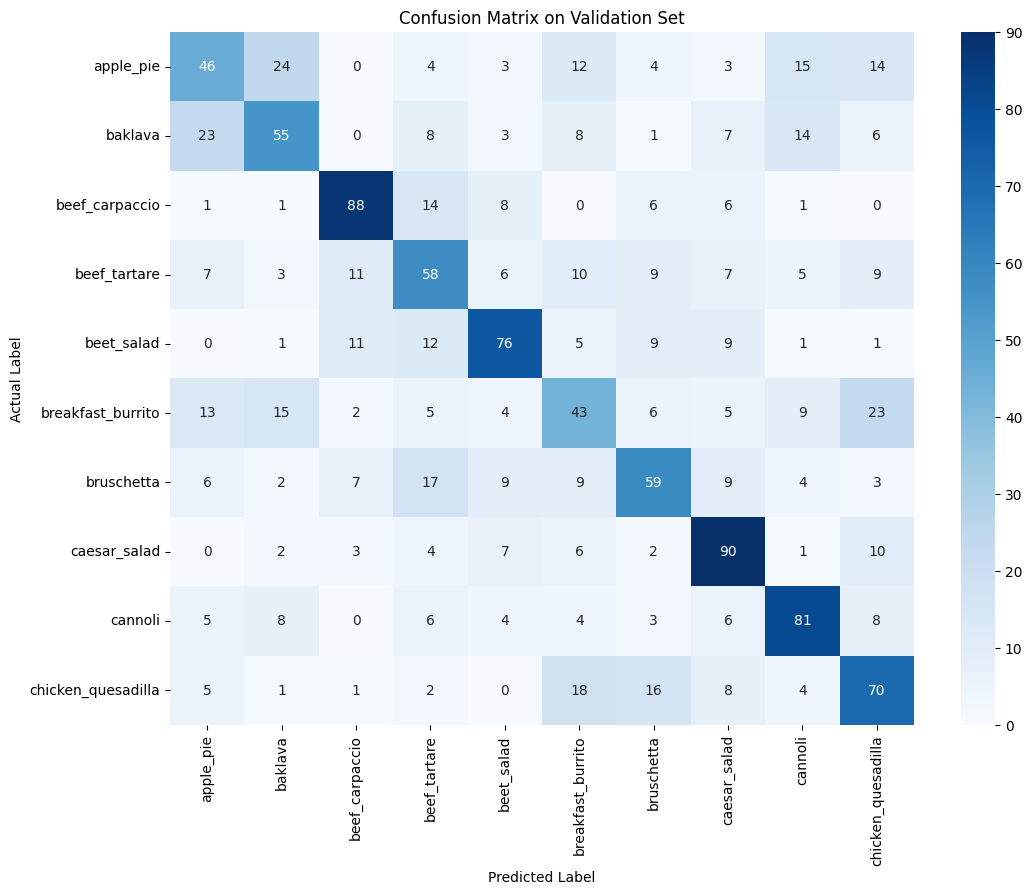

In [34]:
print("\n--- Starting Detailed Evaluation on Validation Set ---")

# 1. Load the weights of your best trained model
best_model_path = 'best_custom_cnn_model.pth' # Path to your saved model
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

# 2. Set the model to evaluation mode (CRITICAL STEP)
model.eval()

# Variables to store all predictions and labels
all_preds = []
all_labels = []

# 3. Loop through the validation data without calculating gradients
with torch.no_grad():
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Append batch predictions and labels to the main lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Import necessary modules from scikit-learn and seaborn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Get the class names from your dataset object
class_names = train_dataset.classes # Or however you have them stored

# 4. Calculate and print the detailed metrics using scikit-learn
print("\nClassification Report (on Validation Data):")
# This single function calculates precision, recall, and F1-score for each class
print(classification_report(all_labels, all_preds, target_names=class_names))

# 5. Visualize the predictions with a confusion matrix
print("\nConfusion Matrix (on Validation Data):")
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(12, 9))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


--- Starting Final Evaluation on Test Set ---
Loaded best model from: best_custom_cnn_model.pth

Final Accuracy on the 1250 test images: 53.20%

Classification Report:
                    precision    recall  f1-score   support

         apple_pie       0.45      0.39      0.42       125
           baklava       0.55      0.46      0.50       125
    beef_carpaccio       0.65      0.70      0.67       125
      beef_tartare       0.45      0.46      0.46       125
        beet_salad       0.65      0.64      0.65       125
 breakfast_burrito       0.40      0.37      0.38       125
        bruschetta       0.48      0.38      0.43       125
      caesar_salad       0.63      0.79      0.70       125
           cannoli       0.54      0.58      0.56       125
chicken_quesadilla       0.46      0.53      0.49       125

          accuracy                           0.53      1250
         macro avg       0.53      0.53      0.53      1250
      weighted avg       0.53      0.53      0.53

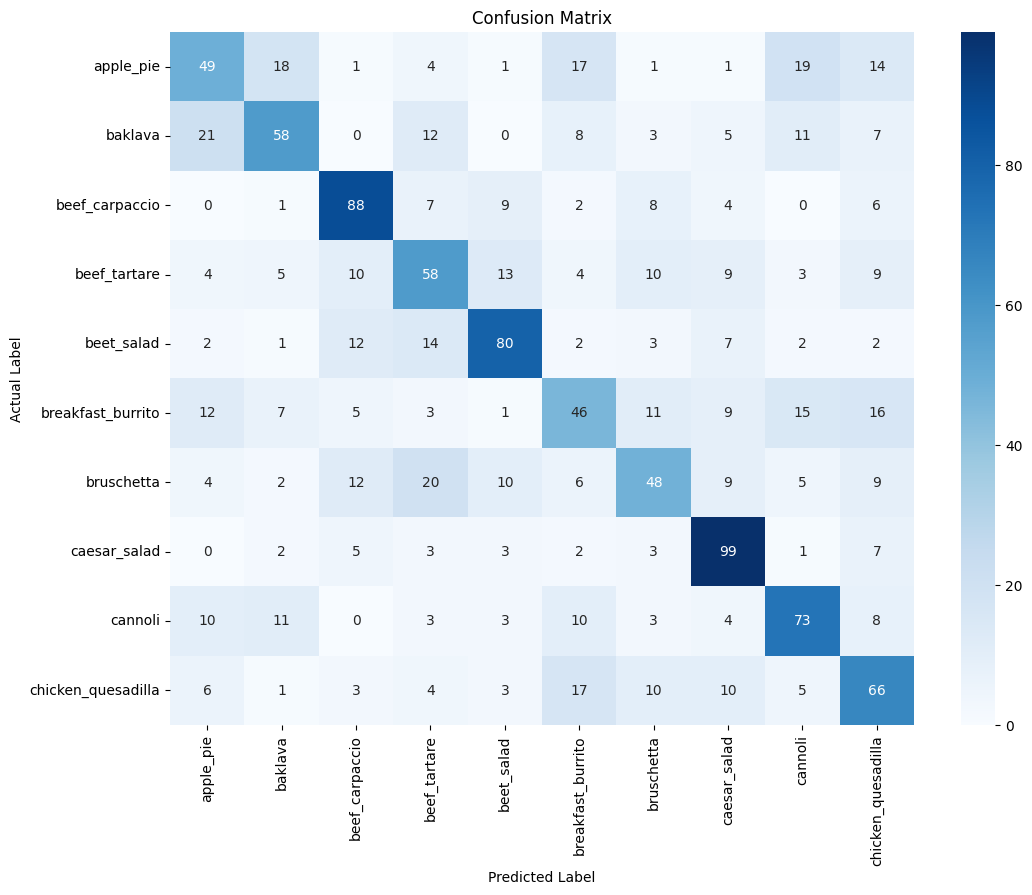

In [35]:
# =============================================================================
# 8. FINAL MODEL TESTING
# =============================================================================
print("\n--- Starting Final Evaluation on Test Set ---")

# 1. Load the best performing model's weights
# This assumes your early stopping logic saved the best model.
best_model_path = 'best_custom_cnn_model.pth' # Make sure this path is correct
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

# 2. Set the model to evaluation mode
# This is critical to do before testing! It turns off layers like Dropout.
model.eval()

# Variables to store predictions and true labels for later analysis
all_preds = []
all_labels = []

# 3. Disable gradient calculations for efficiency
with torch.no_grad():
    correct = 0
    total = 0
    # 4. Loop through the test_loader
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 5. Calculate and print the final accuracy
final_accuracy = 100 * correct / total
print(f'\nFinal Accuracy on the {total} test images: {final_accuracy:.2f}%')

# =============================================================================
# 9. DEEPER ANALYSIS (HIGHLY RECOMMENDED FOR YOUR REPORT)
# =============================================================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get the class names from your dataset object
class_names = train_dataset.classes # Or however you have them stored

# Print the classification report (includes precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate and display the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(12, 9))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


--- Visualizing Example Predictions for Each Class ---


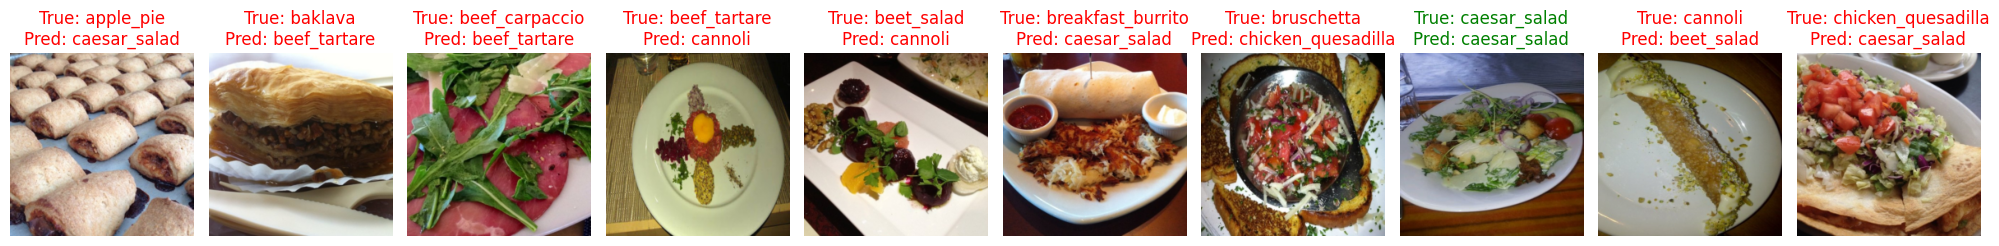

In [58]:
# =============================================================================
# 10. VISUALIZE EXAMPLE PREDICTIONS FOR EACH CLASS
# =============================================================================
print("\n--- Visualizing Example Predictions for Each Class ---")

# Create a grid to display one example per class
num_classes = len(class_names)
fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

# We'll track which classes we've found examples for
found_classes = set()

# Get one batch from the test loader
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Move the model to the device (GPU if available)
model.to(device)

# Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Convert images back to CPU and undo normalization for display
images = images.cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
images = images * std + mean  # undo normalization
images = torch.clamp(images, 0, 1)  # clamp to valid image range

# Display one example per class
for idx in range(len(images)):
    true_label = labels[idx].item()
    pred_label = preds[idx].item()

    # If we haven't shown this class yet
    if true_label not in found_classes:
        found_classes.add(true_label)

        # Get the appropriate subplot
        ax = axes[true_label]

        # Convert image for display (permute from CxHxW to HxWxC)
        img = images[idx].permute(1, 2, 0).numpy()

        # Plot the image
        ax.imshow(img)
        ax.axis('off')

        # Set title with true and predicted class
        title_color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                    color=title_color)

    # Stop when we've found all classes
    if len(found_classes) == num_classes:
        break

# If we didn't find all classes in the first batch, keep looking
if len(found_classes) < num_classes:
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Move the model to the device again (important if device changes or model reloaded)
        model.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        images = images.cpu()
        images = images * std + mean
        images = torch.clamp(images, 0, 1)

        for idx in range(len(images)):
            true_label = labels[idx].item()
            pred_label = preds[idx].item()

            if true_label not in found_classes:
                found_classes.add(true_label)

                # Create a new figure if we didn't make one earlier
                if num_classes != len(axes):
                    fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

                ax = axes[true_label]
                img = images[idx].permute(1, 2, 0).numpy()
                ax.imshow(img)
                ax.axis('off')
                title_color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                            color=title_color)

            if len(found_classes) == num_classes:
                break
        if len(found_classes) == num_classes:
            break

plt.tight_layout()
plt.show()

Improving results using RESNET18

In [59]:
import torchvision.models as models
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]


Testing ResNet18

In [12]:
# =============================================================================
# 1. SETUP AND IMPORTS
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models # Import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import time

# =============================================================================
# 2. CONFIGURATION AND HYPERPARAMETERS
# =============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters for Transfer Learning
NUM_EPOCHS = 20 # Transfer learning is faster, may not need as many epochs
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_CLASSES = 10

# =============================================================================
# 3. DATA PREPARATION AND LOADING (Same as before)
# =============================================================================
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

base_data_dir = '/content/drive/MyDrive/AI_ML_course_2_term/DL_project/food-101/'
train_dir = os.path.join(base_data_dir, 'train')
validation_dir = os.path.join(base_data_dir, 'validation')
test_dir = os.path.join(base_data_dir, 'test')

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Data successfully loaded.")

# =============================================================================
# 4. MODEL DEFINITION (This is the main change)
# =============================================================================
print("Loading pre-trained ResNet18 model...")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for our 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model = model.to(device)
print("ResNet18 model is ready.")

# =============================================================================
# 5. LOSS FUNCTION AND OPTIMIZER (This is the other change)
# =============================================================================
criterion = nn.CrossEntropyLoss()
# IMPORTANT: We only pass the parameters of the final, unfrozen layer to the optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

# =============================================================================
# 6. TRAINING AND VALIDATION LOOP (This is YOUR exact code - no changes needed)
# =============================================================================
patience = 7
patience_counter = 0
best_val_loss = float('inf')
best_model_path = 'best_resnet18_model.pth' # Changed filename for clarity
print(f"Early stopping is enabled with a patience of {patience}.")

print("Starting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss_epoch = running_loss / len(train_loader)
    val_loss_epoch = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), best_model_path)
        print(f'Validation loss improved. Saving model to {best_model_path}')
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

end_time = time.time()
print(f"Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes")

print(f"Loading best model from {best_model_path} for final testing.")
model.load_state_dict(torch.load(best_model_path))


Using device: cuda
Data successfully loaded.
Loading pre-trained ResNet18 model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 255MB/s]


ResNet18 model is ready.
Early stopping is enabled with a patience of 7.
Starting training...
Epoch [1/20], Train Loss: 1.6261, Val Loss: 1.1131, Val Accuracy: 66.64%
Validation loss improved. Saving model to best_resnet18_model.pth
Epoch [2/20], Train Loss: 1.2125, Val Loss: 1.0159, Val Accuracy: 66.64%
Validation loss improved. Saving model to best_resnet18_model.pth
Epoch [3/20], Train Loss: 1.1266, Val Loss: 0.9387, Val Accuracy: 68.64%
Validation loss improved. Saving model to best_resnet18_model.pth
Epoch [4/20], Train Loss: 1.0695, Val Loss: 0.8707, Val Accuracy: 70.64%
Validation loss improved. Saving model to best_resnet18_model.pth
Epoch [5/20], Train Loss: 1.0429, Val Loss: 0.8666, Val Accuracy: 71.12%
Validation loss improved. Saving model to best_resnet18_model.pth
Epoch [6/20], Train Loss: 1.0219, Val Loss: 0.8825, Val Accuracy: 71.84%
Validation loss did not improve. Patience: 1/7
Epoch [7/20], Train Loss: 1.0110, Val Loss: 0.8771, Val Accuracy: 71.44%
Validation loss di

<All keys matched successfully>


--- Starting Detailed Evaluation on Validation Set ---
Loaded best model from: best_resnet18_model.pth

Classification Report (on Validation Data):
                    precision    recall  f1-score   support

         apple_pie       0.69      0.58      0.63       125
           baklava       0.75      0.80      0.78       125
    beef_carpaccio       0.80      0.72      0.76       125
      beef_tartare       0.63      0.75      0.68       125
        beet_salad       0.67      0.70      0.69       125
 breakfast_burrito       0.70      0.73      0.71       125
        bruschetta       0.64      0.78      0.71       125
      caesar_salad       0.83      0.78      0.80       125
           cannoli       0.81      0.71      0.76       125
chicken_quesadilla       0.82      0.71      0.76       125

          accuracy                           0.73      1250
         macro avg       0.73      0.73      0.73      1250
      weighted avg       0.73      0.73      0.73      1250


Confusi

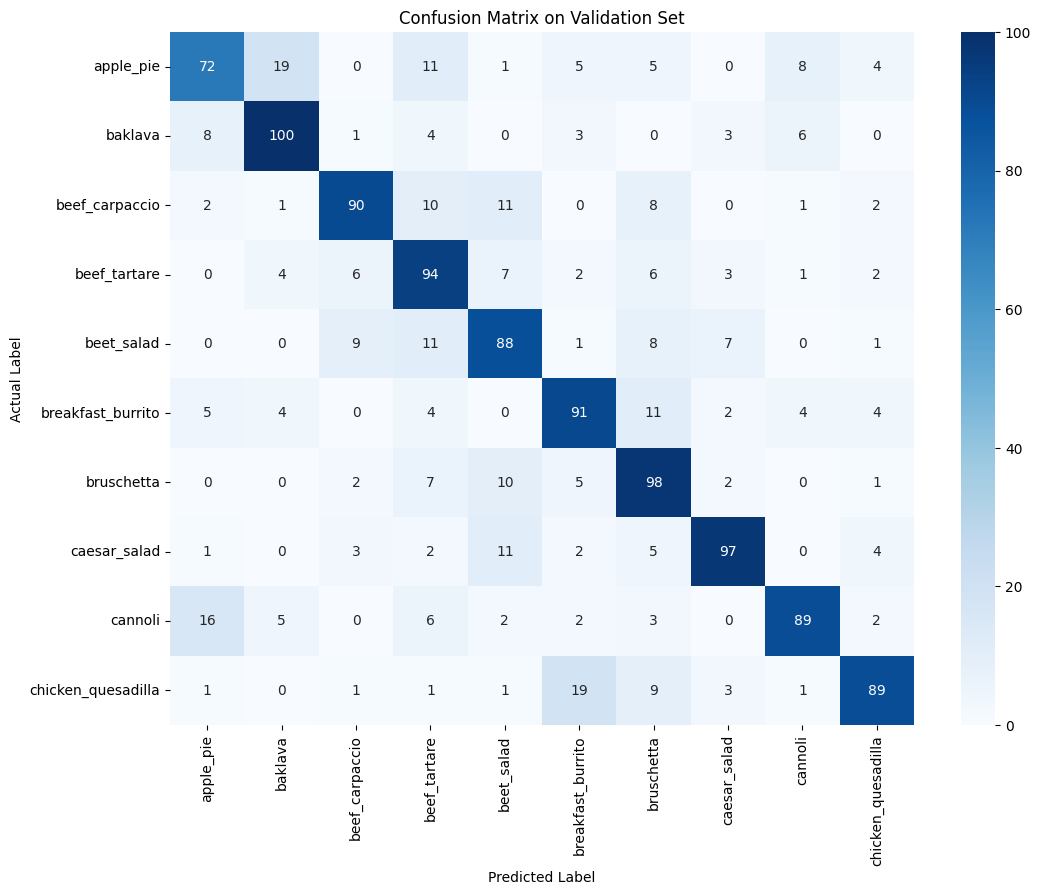

In [13]:
print("\n--- Starting Detailed Evaluation on Validation Set ---")

# 1. Load the weights of your best trained model
best_model_path = 'best_resnet18_model.pth' # Path to your saved model
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

# 2. Set the model to evaluation mode (CRITICAL STEP)
model.eval()

# Variables to store all predictions and labels
all_preds = []
all_labels = []

# 3. Loop through the validation data without calculating gradients
with torch.no_grad():
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Append batch predictions and labels to the main lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Import necessary modules from scikit-learn and seaborn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Get the class names from your dataset object
class_names = train_dataset.classes # Or however you have them stored

# 4. Calculate and print the detailed metrics using scikit-learn
print("\nClassification Report (on Validation Data):")
# This single function calculates precision, recall, and F1-score for each class
print(classification_report(all_labels, all_preds, target_names=class_names))

# 5. Visualize the predictions with a confusion matrix
print("\nConfusion Matrix (on Validation Data):")
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(12, 9))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


Gerando visualização da Matriz de Confusão...


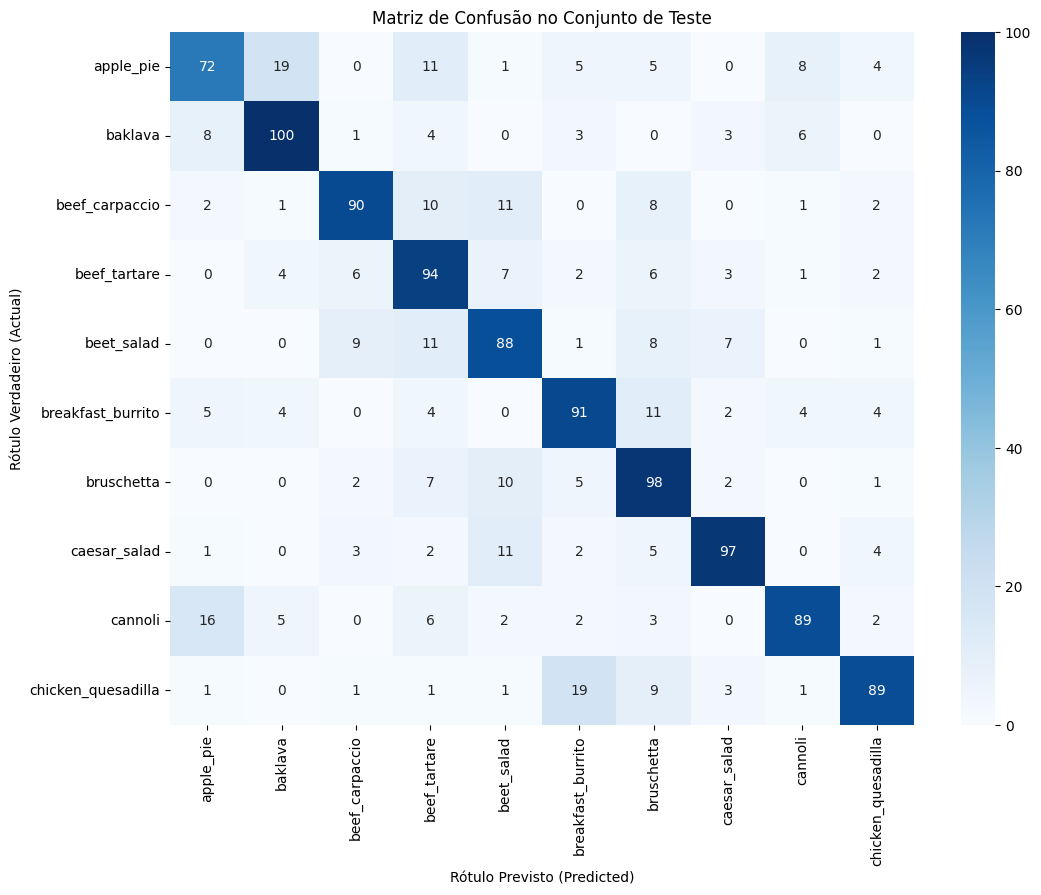


Visualização concluída.


In [15]:
# =============================================================================
# 5. VISUALIZAR A MATRIZ DE CONFUSÃO (OPCIONAL, MAS RECOMENDADO)
# =============================================================================
print("\nGerando visualização da Matriz de Confusão...")
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(12, 9))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusão no Conjunto de Teste')
plt.ylabel('Rótulo Verdadeiro (Actual)')
plt.xlabel('Rótulo Previsto (Predicted)')
plt.show()

print("\nVisualização concluída.")


--- Visualizing Example Predictions for Each Class ---


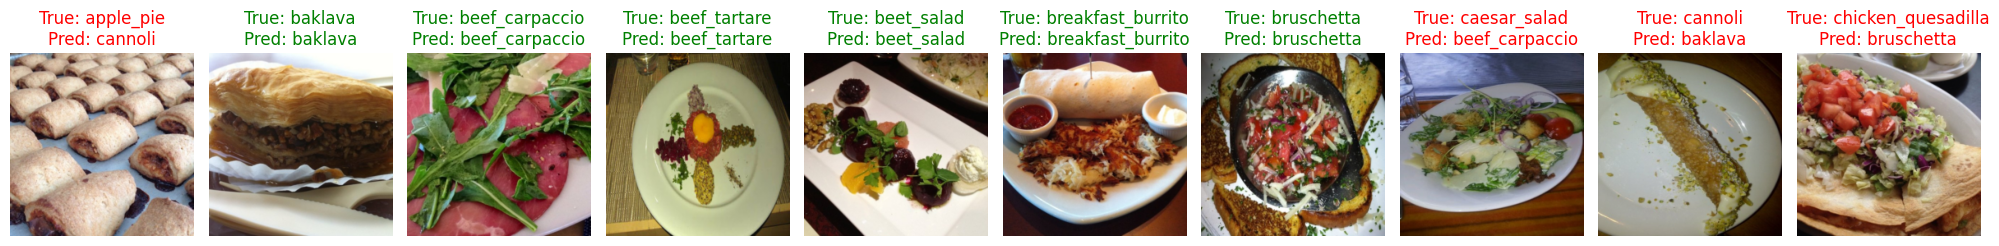

In [16]:
# =============================================================================
# 10. VISUALIZE EXAMPLE PREDICTIONS FOR EACH CLASS
# =============================================================================
print("\n--- Visualizing Example Predictions for Each Class ---")

# Create a grid to display one example per class
num_classes = len(class_names)
fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

# We'll track which classes we've found examples for
found_classes = set()

# Get one batch from the test loader
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Move the model to the device (GPU if available)
model.to(device)

# Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Convert images back to CPU and undo normalization for display
images = images.cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
images = images * std + mean  # undo normalization
images = torch.clamp(images, 0, 1)  # clamp to valid image range

# Display one example per class
for idx in range(len(images)):
    true_label = labels[idx].item()
    pred_label = preds[idx].item()

    # If we haven't shown this class yet
    if true_label not in found_classes:
        found_classes.add(true_label)

        # Get the appropriate subplot
        ax = axes[true_label]

        # Convert image for display (permute from CxHxW to HxWxC)
        img = images[idx].permute(1, 2, 0).numpy()

        # Plot the image
        ax.imshow(img)
        ax.axis('off')

        # Set title with true and predicted class
        title_color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                    color=title_color)

    # Stop when we've found all classes
    if len(found_classes) == num_classes:
        break

# If we didn't find all classes in the first batch, keep looking
if len(found_classes) < num_classes:
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Move the model to the device again (important if device changes or model reloaded)
        model.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        images = images.cpu()
        images = images * std + mean
        images = torch.clamp(images, 0, 1)

        for idx in range(len(images)):
            true_label = labels[idx].item()
            pred_label = preds[idx].item()

            if true_label not in found_classes:
                found_classes.add(true_label)

                # Create a new figure if we didn't make one earlier
                if num_classes != len(axes):
                    fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

                ax = axes[true_label]
                img = images[idx].permute(1, 2, 0).numpy()
                ax.imshow(img)
                ax.axis('off')
                title_color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                            color=title_color)

            if len(found_classes) == num_classes:
                break
        if len(found_classes) == num_classes:
            break

plt.tight_layout()
plt.show()